# Synchrotron Radiation
This Notebook contains 5 excercises for a total of 18 marks. Please submit on Ulwazi.

## Pre-Requisites
As usual, we start with importing the necessary modules.

In [ ]:
from astropy import units as u
from astropy import constants as c

from astropy.modeling.powerlaws import PowerLaw1D

import numpy as np

import matplotlib.pyplot as plt

from math import pi
from numpy import sqrt, cos, sin, tan, abs

## Synchrotron Frequency

The synchrotron frequency is (see slide 40)
$$\nu_\mathrm{sync} = \frac{1}{2\pi} \left( \frac{U}{m c^2} \right)^2 \frac{qB}{m} \sin \phi$$
We are interested in electrons only, so we can keep the charge and mass fixed. Here is a function to do the calculation:

In [ ]:
def nu_sync (U, B, phi = 90*u.degree) : 
    
    ret = U**2 * c.e.si * B * sin(phi) / 2 / pi / c.m_e**3 / c.c**4
    
    return ret.decompose().to(u.Hz)

The lecture example takes an assumed magnetic field in the Crab Nebula of $B = 5 \times 10^{-8}\,\mathrm{T}$.
We have seen that there are electrons with an energy of $U = 21\,\mathrm{TeV}$. The synchrotron frequency is

In [ ]:
nu = nu_sync(21*u.TeV, 5e-8*u.T)

In [ ]:
nu

And the photon energy is

In [ ]:
E = nu*c.h

In [ ]:
E.to(u.keV)

### Exercise
In order to fill the table on the tutorial sheet you need a function to calculate the electron energy $U$ in eV from the synchrotron frequency. Write a function to do this calculation.

**[3 marks]**

In [ ]:
def Eelectron_sync (nu, B, phi = 90*u.degree) :
    
    # fill in your code here
    E = 0*u.eV
    
    return E.to(u.eV)

Now we test the function.

In [ ]:
Eelectron_sync([1,10]*u.keV/c.h, 5e-8*u.T)

Expected Output:

[6.7164753×10^12, 2.123936×10^13]eV

## Power Spectrum
We want to write a function to calculate the power spectrum of the synchrotron radiation of a mono-energetic electron. The equation (see slide 43) is
$$ P(\omega) = \frac{\sqrt{3}}{8 \pi^2} \frac{q^3 B \sin \phi}{\epsilon_0 c m} F\left( \frac{\omega}{\omega_c} \right)$$
with
$$ F(x) = x \int_x^\infty K_{5/3} (z) dz $$
and $K_{5/3} (z)$ being a modified Bessel function of the 2nd kind.

In order write a function for the entire power spectrum of an electron we will need some more modules:

In [ ]:
import scipy.integrate as integrate
import scipy.special as special

The function $F(x)$ can be programmed as follows. (see https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html)

In [ ]:
def F(x) :
    ## https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html
    
    #K53 = special.kv(5./3, x)
    result = x*integrate.quad(lambda z: special.kv(5./3,z), x, np.inf)[0]
    
    return result

But we need something that will work on a vector of x values:

In [ ]:
def F_vec(x_vec) :
    
    integrateArray = []
    
    for x in x_vec :
        integrate = F(x)
        integrateArray.append(integrate)
    
    return integrateArray    

Here is a function to calculate the power radiated by an electron with energy $E$ in a magnetic field $B$ with a pitch angle $\phi$. nu can be a single frequency or an array of frequencies. Everything else must be a scalar.

In [ ]:
def Psync(nu, E, B, phi = 90*u.degree) : 

    nu_over_nus = nu / nu_sync (E, B, phi)
    
    nu_over_nus = nu_over_nus.decompose().value
    
    if type(nu_over_nus) is np.ndarray :
        #print('array mode')
        ret = np.array(F_vec(nu_over_nus))*u.one
    else :
        #print('single mode')
        ret = F(nu_over_nus)*u.one


    ret *= sqrt(3)/8/pi**2 
    
    ret *= c.e.si**3 * B * sin(phi) / c.m_e / c.c / c.eps0.si


    return ret.to(u.W/u.Hz)


Let's calulcate the power for a range of frequencies. Let's use an electron energy of $U = 19\,\mathrm{TeV}$ and $B = 5\times10^{-8}\,\mathrm{T}$. 

In [ ]:
U = 19*u.TeV
B = 5e-8*u.T

In [ ]:
frequencies = np.logspace(13, 19, 601) * u.Hz

In [ ]:
P = Psync(frequencies, U, B)

In [ ]:
P

Let's make a plot of it:

In [ ]:
plt.plot(frequencies, P)

plt.xscale('log')

plt.xlabel('frequency [{}]'.format(frequencies.unit))
plt.ylabel('P [{}]'.format(P.unit))

### Exercise
Make plots similar to the plots on slide 24 of the lecture on Synchrotron Radiation I. Use 0.1, 1 and 10 TeV for the electron energy and a magnetic field of $B = 10^{-8}\,\mathrm{T}$ for the first plot, and an electron energy of $U = 10\,\mathrm{TeV}$ and magnetic fields of $10^{-10}\,\mathrm{T}$,$10^{-9}\,\mathrm{T}$, and $10^{-8}\,\mathrm{T}$ for the second plot.

**[6 marks]**

In [ ]:
# for plot 1
U_1 = [0.1, 1, 10] *u.TeV
B_1 = 1e-8 * u.T

# fill in your code here

Expected Output:
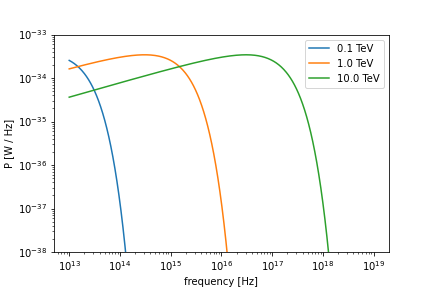

In [ ]:
# for plot 2
U_2 = 10 *u.TeV
B_2 = [1e-10, 1e-9, 1e-8] * u.T

# fill in your code here

Expected Output:
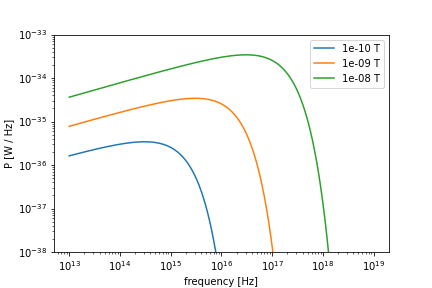

## Emitted Power in the Relativistic Case 

We will use the equation from slide 8 of the lecture Synchrotron Radiation II. Electron energy and magnetic field are as above:

In [ ]:
U

In [ ]:
B

As the electron is highly relativistic we can set $\beta$ to $1$.

In [ ]:
beta = 1

In [ ]:
P = 2./3 * c.eps0.si * c.sigma_T * beta**2 / (c.c * c.m_e**2) * B**2 * U**2

In [ ]:
P.to(u.W)

## Synchrotron Cooling Time

The synchrotron cooling time (lecture Synchrotron Radiation II, slide 13) is
$$
\tau_\mathsf{sync} (U) = \frac{3}{2} \frac{c m_e^2}{\varepsilon_0 \sigma_T \beta B^2 U}
$$
where $B$ is the magnetic field and $U$ is the total energy of the electron. We will be dealing only with electrons so we will use the eletron mass for the particle's mass.
### Exercise
Write a function that calculates the cooling time for a given magnetic field and (an array of) electron energies.

**[3 marks]**

In [ ]:
def CoolingTime_Sync (U, B = 5e-8*u.T, beta = 1.) :
    
    # your code here
    tau = U.value * 0 * u.s
    
    return tau.to(u.s)

Let's test the function for an array of four electron energies:

In [ ]:
U = [1e-1, 1, 10] * u.TeV
CoolingTime_Sync (U)

Expected Output:
[1.5816436×10^10, 1.5816436×10^9, 1.5816436×10^8]s

### Exercise
Make a plot of the cooling time vs. electron energy for electron energies between 1 MeV and 100 TeV.

**[3 marks]**

In [ ]:
# your code here

Expected Output:

## Synchrotron Radiation from an Electron Population
So far we have dealt with mono-energetic electrons. We usually observe electrons of many different energies, often they follow a power law. Let's define our power law as in the Introduction.

In [ ]:
E_0 = 1 * u.TeV
A = 10 / u.TeV
Gamma = 2.5

In [ ]:
PL = PowerLaw1D(A, E_0, Gamma)

We define a range of photon frequencies with 600 log-spaced bins going from $10^{13}$ Hz to $10^{19}$ Hz:

In [ ]:
frequencies = np.logspace(13, 19, 601) * u.Hz

And we use our magnetic field of $B = 10^{-8}\,\mathsf{T}$:

In [ ]:
B = 1e-8 * u.T

Let's get the synchrotron spectra for electron energies of 100 GeV, 1 TeV and 10 TeV: 

In [ ]:
spec_100GeV = Psync(frequencies, 100*u.GeV, B)
spec_1TeV = Psync(frequencies, 1*u.TeV, B)
spec_10TeV = Psync(frequencies, 10*u.TeV, B)

But we have more electrons at 1 GeV then at 10 GeV. How many electrons? This comes from the power law defined above. We have to multiply the spectrum with the number of electrons:

In [ ]:
spec_100GeV *= PL(100*u.GeV)
spec_1TeV *= PL(1*u.TeV)
spec_10TeV *= PL(10*u.TeV)

We have to sum these spectra to get the total emission:

In [ ]:
spec_sum = spec_100GeV.copy()

spec_sum += spec_1TeV
spec_sum += spec_10TeV

In [ ]:
plt.loglog(frequencies, spec_sum, label = "total emission", linewidth = 4)

plt.loglog(frequencies, spec_100GeV, label = "100 GeV")
plt.loglog(frequencies, spec_1TeV, label = "1 TeV")
plt.loglog(frequencies, spec_10TeV, label = "10 TeV")

plt.legend()

#p we need to limit the y range a bit:
plt.ylim(1e-40,1e-30)

plt.xlabel('frequency [{}]'.format(frequencies.unit))
plt.ylabel('P [{}]'.format(spec_sum.unit))

### Exercise
Keep the electron energy range from 100 GeV to 10 TeV. Make the same plot as above but for many more intermediate energies. Create an array of electron energies and loop over it. You should have enough intermediate energies that the total emission is almost a power law.

**[3 marks]**

Extra exercise: Take the part of the spectrum following clearly a power law. Find out the spectral index. You can do that by taking two values and doing the calculation on a sheet of paper. You can also do a least-square fit of the total emission.

In [ ]:
# Here is an empty spectrum to be filled in

spec_sum = np.zeros(len(frequencies)) * u.W / (u.Hz * u.TeV)

In [ ]:
# your code here

Expected output: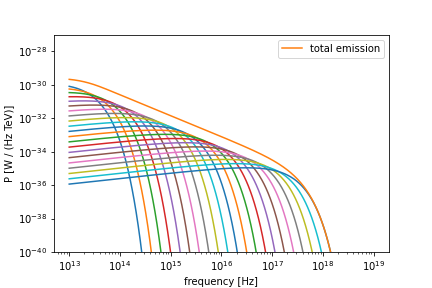

## Submission

Before you submit your work you should make a few checks that everything works fine.

1. Save your notebook as a PDF (File->Download As->PDF). This document will help you debugging in the next step.
1. If PDF export does not work: You can do File->Print Preview and then print to a file.
1. Restart the kernel and rerun the entire notebook (Kernel->Restart & Run All). This will delete all variables (but not your code) and rerun the notebook in one go. If this does not go through the endthen you have to fix it. You will see at which cell the run stopped. A common mistake is using a variable that is defined only at a later stage.
1. You think you fixed everything? Redo step 2 (Kernel->Restart & Run All)

You have to download and submit 2 files, the jupyter notebook and a pdf.
- Jupyter notebook. File->Download As->Notebook (.ipynb). Save this file on your disk.
- PDF file. File->Download As->PDF. Save this file on your disk.
- If PDF export does not work. You can do File->Print Preview and then print to a file.

Please submit the two files on Ulwazi.